# Programming tips and common mistakes (Python version)

### Packages used throughout

### 1. Computing the principal components

#### Toy data

This creates a matrix with a 5 dimensional signal and random noise. Look at the scree plot below, this is basically what happens when some singular values are very large and the rest is small.

In [ ]:
from scipy.stats import ortho_group
from numpy.linalg import qr
from numpy.random import default_rng

rng = default_rng()

# Create a random orthogonal matrix of size 40 x 5
U = qr(rng.standard_normal(size=(40, 5)))[0]
# or
U = ortho_group.rvs(40)[:, :5]
S = np.diag([7.0, 6.0, 5.0, 4.0, 3.0])

X = U @ S @ U.T + 1 / np.sqrt(40.0) * rng.standard_normal(size=(40, 40))

#### Alternative 1: Directly from the SVD 

In [ ]:
from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd

# Centres and (!) scales the columns with standard options
X_pp = StandardScaler().fit_transform(X)
# # Only centres the columns
# X_pp = StandardScaler(with_std=False).fit_transform(X)
X_svd = svd(X_pp)

# Note that Numpy's `svd` returns U, D, and V^T instead of V
principal_directions = X_svd[2].T
explained_variance = X_svd[1] ** 2 / (X_pp.shape[0] - 1)
principal_components1 = X_pp @ X_svd[2].T
# or
principal_components2 = X_svd[0] @ np.diag(X_svd[1])

Check that the two ways of computing the principal components are the same

In [ ]:
# Check equality
assert np.allclose(principal_components1, principal_components2)

#### Alternative 2: `sklearn.decomposition.PCA`

Note that the `PCA` transformer from scikit-learn automatically centres the data. However, if you want to also scale your data you have to perform this separately.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_pp = StandardScaler().fit_transform(X)
pca = PCA().fit(X_pp)

# The PCA object offers convenient ways of accessing the
# principal directions and explained variance
pca.components_;
pca.explained_variance_;

# To get the principal components, the `transform` method of the
# PCA object can be used
principal_components_pca = pca.transform(X_pp)

Compare with manual computation above. Note that the PCA object in scikit-learn takes two different approaches than I took in my example above:

1. Principal directions are reported in the transposed form
2. The sign of the principal directions, i.e. of each column, can be flipped.

Compute the signs. Note that the principal directions are the same, but that sometimes they point in the direction 180 degrees opposite to the one we computed above.

In [6]:
signs = np.diag(pca.components_ @ principal_directions)

In [7]:
assert np.allclose(explained_variance, pca.explained_variance_)
assert np.allclose(principal_components1, principal_components_pca @ np.diag(signs))

#### Dimension reduction

Dimension reduction with PCA is performed by looking at a scree plot, deciding how many components to keep, say, $k$, and then only keeping these first $k$ principal components, i.e. the first $k$ columns of the matrix `principal_components`.

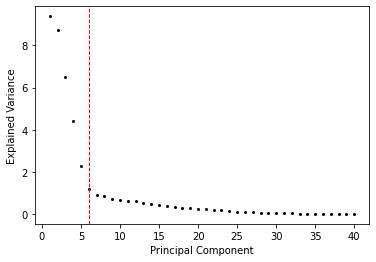

In [8]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.axvline(6, linestyle="dashed", color="red", linewidth=1)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance");

Looking at the scree plot, a good cut-off is after 5 or 6 principal components. So we could keep the first six columns of `principal_components`.

In [9]:
pc_selection = principal_components1[: ,:6]

### 2. Creating random subsamples of the data

There seems to be confusion about creating random subsamples and I think it comes from how bootstrapping works.

In bootstrapping, we start with a dataset with $n$ observations and then we choose observations repeatedly *with replacement*, i.e. there is a chance to sample the same observation more than once.

In subsampling, we are choosing $k < n$ observations *without replacement*. This way, we can be sure to have unique observations.

In [10]:
from numpy.random import default_rng

rng = default_rng(247)

n = 100
all_idx = list(range(n))

# boostrapping
bootstrap_idx = rng.choice(n, n, replace=True)
# subsampling
subsample_idx = rng.choice(n, int(0.8 * n), replace=False)

In [11]:
len(np.unique(bootstrap_idx))

58

In [12]:
len(np.unique(subsample_idx))

80

Note how the subsample contains 80 unique indices as expected whereas the bootstrapping samples contains 100 indices but, in this particular run, only 58 unique indices, i.e. observations have been picked repeatedly.

### 3. Confusion about scikit-learn's `average` option in scores

**tl;dr Set `average='binary'` in a binary classification problem. In a multiclass classification problem, set `average='macro'` to get average scores across classes or `average=None` to get the score for each class separately.**

Every year again it seems that there is some confusion about the option `average` in scoring functions in the `sklearn.metrics` module (e.g. `sklearn.metrics.recall_score`). I am always a bit surprised since there is a clear disclaimer in the documentation that **this option applies only for multiclass classification (i.e. more than two classes)** and should otherwise be set to `'binary'`. If you have a binary classification problem and set the `average` option to anything other than `'binary'`, then you will get wrong results!

If you actually want to do multiclass classification, then this argument is useful and the scikit-learn documentation has [a good description](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel) of what these options specify.

Let us first look at what happens if you use the `average` option wrong in a binary classification setting.

#### Toy data - Binary

In [13]:
from numpy.random import default_rng

rng = default_rng(666)

labels_binary = np.sort([0, 1] * 50)
features_binary = np.concatenate([
    rng.standard_normal(size=(50, 2)) + np.array([[1.0, 1.0]]),
    rng.standard_normal(size=(50, 2)) + np.array([[-1.0, -1.0]]),
])

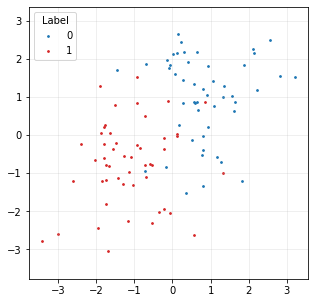

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.grid(alpha=0.25)
for i in np.unique(labels_binary):
    ax.scatter(
        features_binary[labels_binary == i, 0],
        features_binary[labels_binary == i, 1],
        c='tab:red' if i == 1 else 'tab:blue',
        s=3,
        label=i
    )
ax.axis('equal')
ax.legend(title='Label');

#### Binary classification and scoring

In [15]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Fit a QDA model and predict the labels
qda = QuadraticDiscriminantAnalysis().fit(features_binary, labels_binary)
labels_binary_pred = qda.predict(features_binary)

So, since we are in the case of binary classification, you are supposed to leave the `average` option at `'binary'`, which is the default anyways, and run the scoring as follows:

In [16]:
from sklearn.metrics import recall_score, f1_score, precision_score

(
    recall_score(labels_binary, labels_binary_pred, average='binary', pos_label=1),
    f1_score(labels_binary, labels_binary_pred),
    precision_score(labels_binary, labels_binary_pred),
)

(0.88, 0.8979591836734694, 0.9166666666666666)

**Note** that by default, these scoring functions will always take class `1` as the positive case (that is, the integer 1). You have to specify the argument `pos_label` if you want to use any other name for the positive class.

**What happens if you set average wrong?**

In [17]:
(
    recall_score(labels_binary, labels_binary_pred, average='macro'),
    f1_score(labels_binary, labels_binary_pred, average='macro'),
    precision_score(labels_binary, labels_binary_pred, average='macro'),
)

(0.9, 0.8999599839935974, 0.9006410256410255)

This result isn't far from the setting `'binary'`, but it is still wrong. Why? Take sensitivity as an example:

Define

- `TP = reference == 1 and prediction == 1`,
- `TN = reference == 0 and prediction == 0`, 
- `FN = reference == 1 and prediction == 0`, and 
- `FP = reference == 0 and prediction == 1`.

What macro does is:

1. Consider class 1 as positive, compute `sensitivity(class 1 positive) = TP / (TP + FN)`
2. Consider class 2 as positive, compute `sensitivity(class 0 positive) = TN / (TN + FP) = Specificity(class 1 positive)`
3. Compute and return `sensitivity = (sensitivity(class 1 positive) + sensitivity(class 0 positive)) / 2`

So clearly this is not what we are out after.

In [18]:
from sklearn.metrics import accuracy_score

(
    accuracy_score(labels_binary, labels_binary_pred),
    recall_score(labels_binary, labels_binary_pred, average='micro'),
    f1_score(labels_binary, labels_binary_pred, average='micro'),
    precision_score(labels_binary, labels_binary_pred, average='micro'),
)

(0.9, 0.9, 0.9, 0.9)

Micro in the binary case leads to particularly strange results. Why? Take sensitivity as an example:

Let `TP`, `TN`, `FN`, and `FP` be as above, then micro determines the numerators and denominators of

1. `sensitivity(class 1 positive) = TP / (TP + FN)` and
2. `sensitivity(class 0 positive) = TN / (TN + FP) = Specificity(class 1 positive)`

and computes sensitivity by adding the two numerators and denominators first and adding them then, i.e. `sensitivity = (TP + TN) / (TP + FN + TN + FP)`. However, this is the accuracy of a binary classification problem and not its sensitivity anymore. Doing the same with precision also leads to the accuracy of the model and since the f1 score is just a combination of recall and precision it ends up in the same fashion.

#### Toy data - Multi-class

In [19]:
from numpy.random import default_rng

rng = default_rng(777)

labels_multiclass = np.sort([0, 1, 2, 3] * 50)
features_multiclass = np.concatenate([
    rng.standard_normal(size=(50, 2)) + np.array([[1.0, 1.0]]),
    rng.standard_normal(size=(50, 2)) + np.array([[-1.0, -1.0]]),
    rng.standard_normal(size=(50, 2)) + np.array([[-1.0, 1.0]]),
    rng.standard_normal(size=(50, 2)) + np.array([[1.0, -1.0]]),
])

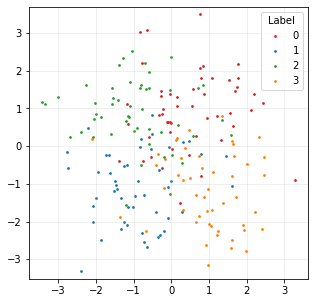

In [20]:
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.grid(alpha=0.25)
for i in np.unique(labels_multiclass):
    ax.scatter(
        features_multiclass[labels_multiclass == i, 0],
        features_multiclass[labels_multiclass == i, 1],
        c=colors[i],
        s=3,
        label=i
    )
ax.axis('equal')
ax.legend(title='Label');

#### Multiclass classification

So what is this argument good for? If there are more than two classes, then classification metrics such as sensitivity/recall or precision are not directly defined. The argument `average` lets you choose a few alternatives of how you want to deal with this problem.

In [21]:
# Fit a QDA model and predict the labels
qda = QuadraticDiscriminantAnalysis().fit(features_multiclass, labels_multiclass)
labels_multiclass_pred = qda.predict(features_multiclass)

The simplest solution is to choose `average=None` which returns an array of results. Element `i` corresponds to the case where class `i` was considered as positive and all other classes were considered as negative.

In [22]:
recall_score(labels_multiclass, labels_multiclass_pred, average=None)

array([0.64, 0.74, 0.72, 0.72])

The option `average='macro'` takes the average of this array.

In [23]:
(
    np.mean(recall_score(labels_multiclass, labels_multiclass_pred, average=None)),
    recall_score(labels_multiclass, labels_multiclass_pred, average='macro')
)

(0.7049999999999998, 0.7049999999999998)

The option `average='weighted'` does the same but forms a weighted average if the class distribution is not equal (which it is here).

In [24]:
(
    np.mean(recall_score(labels_multiclass, labels_multiclass_pred, average=None)),
    recall_score(labels_multiclass, labels_multiclass_pred, average='weighted')
)

(0.7049999999999998, 0.705)

The option `average='micro'` is the most esoteric of the four. It works as described above in the binary example by computing the numerators and denominators for the score, adding them first, and then finally dividing them. Apparently this can help to reduce the influence of a large majority class (i.e. strong class imbalance).

### 4. Accidental modification of NumPy arrays

Python works for the most part on references to variables. Without getting too technical, Python prefers to just pass the location of data around instead of having to copy the data (which might be large) from one location to the other. This can lead to some unexpected behaviour, especially if arrays/lists/... are modified in a function.

Let's start easy, what do I mean by a reference.

In [25]:
a = [1, 2, 3, 4]

Python will store the the list in memory and the variable `a` becomes a reference to the data, i.e. it can be used to access the data.

In [26]:
b = a
b

[1, 2, 3, 4]

As you can see, by assigning, `b` now also is a reference to the data. However, what surprises many is that no copy was performed. Changing `b` will lead to a change in `a`.

In [27]:
b[0] = 0
a

[0, 2, 3, 4]

This is because both `a` and `b` point to the same data.

What makes this more tricky is if lists or arrays are changed in functions, because it may not always be obvious that the object passed to the function will be modified.

In [28]:
def modify_array1(x):
    x[0] = 0

In [29]:
a = [1, 2, 3, 4]
modify_array1(a)
a

[0, 2, 3, 4]

As you can see, `a` gets modified inside the function. In the assignments I have seen some many that were sort of aware of this issue and did the following in the hope that it would not modify the input to the function.

In [30]:
def modify_array2(x):
    y = x
    y[0] = 0
    return y

In [31]:
a = [1, 2, 3, 4]
modify_array2(a)
a

[0, 2, 3, 4]

However, this does not work. The only way to avoid changing the passed object is to properly copy it.

In [32]:
from copy import deepcopy

In [33]:
def modify_array3(x):
    y = deepcopy(x)
    y[0] = 0
    return y

In [34]:
a = [1, 2, 3, 4]
print(modify_array3(a))
a

[0, 2, 3, 4]


[1, 2, 3, 4]

This way, the returned object from `modify_array3` is properly modified, but the outside object passed to the function is not.

NumPy provides a convenient interface for this operation (also because it manages memory in a non-standard way).

In [35]:
def modify_np_array(x):
    y = x.copy()
    y[0] = 0
    return y

In [36]:
a = np.array([1, 2, 3, 4])
print(modify_np_array(a))
print(a)

[0 2 3 4]
[1 2 3 4]


So be careful when modifying lists and arrays that you pass to a function since you might end up with unexpected results otherwise.